In [1]:
# Cell 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from collections import Counter
import community as community_louvain  # requires: pip install python-louvain


In [ ]:
# the data can be downloaded from here https://snap.stanford.edu/data/ERC20-stablecoins.html 
# Cell 2: Data Loading
# Load token transfers data
df = pd.read_csv('token_transfers.csv')
df['datetime'] = pd.to_datetime(df['time_stamp'], unit='s')

# Load event data (adjust encoding if needed)
events = pd.read_csv('event_data.csv', encoding='latin1')
events['datetime'] = pd.to_datetime(events['timestamp'], unit='s')
events['date'] = events['datetime'].dt.date

# Load price data if needed (example for one stablecoin)
price_df = pd.read_csv('price_data_extracted/price_data/usdt_price_data.csv')
price_df['datetime'] = pd.to_datetime(price_df['date']) if 'date' in price_df.columns else pd.to_datetime(price_df.index)
# Define the file paths for each price data CSV
file_paths = {
    'dai': r'price_data_extracted\price_data\dai_price_data.csv',
    'pax': r'price_data_extracted\price_data\pax_price_data.csv',
    'usdc': r'price_data_extracted\price_data\usdc_price_data.csv',
    'usdt': r'price_data_extracted\price_data\usdt_price_data.csv',
    'ustc': r'price_data_extracted\price_data\ustc_price_data.csv',
    'wluna': r'price_data_extracted\price_data\wluna_price_data.csv'
}

# Initialize a dictionary to store each DataFrame
price_data = {}

# Load each CSV file into a DataFrame and print some basic info
for coin, path in file_paths.items():
    try:
        df = pd.read_csv(path)
        price_data[coin] = df
        print(f"Loaded {coin.upper()} price data with shape: {df.shape}")
        print(df.head(), "\n")
    except Exception as e:
        print(f"Failed to load {coin.upper()} data from {path}: {e}")

Loaded DAI price data with shape: (215, 5)
    timestamp    open  high     low   close
0  1648857600  0.9999   1.0  0.9989  1.0000
1  1648944000  1.0000   1.0  0.9989  0.9990
2  1649030400  0.9990   1.0  0.9989  0.9995
3  1649116800  0.9994   1.0  0.9987  0.9999
4  1649203200  0.9999   1.0  0.9988  0.9991 

Loaded PAX price data with shape: (215, 5)
    timestamp  open  high     low   close
0  1648857600   1.0   1.0  0.9962  1.0000
1  1648944000   1.0   1.0  0.9982  1.0000
2  1649030400   1.0   1.0  0.9975  1.0000
3  1649116800   1.0   1.0  0.9986  1.0000
4  1649203200   1.0   1.0  0.9973  0.9998 

Loaded USDC price data with shape: (215, 5)
    timestamp    open  high     low   close
0  1648857600  0.9995   1.0  0.9990  0.9999
1  1648944000  1.0000   1.0  0.9991  0.9993
2  1649030400  0.9993   1.0  0.9985  1.0000
3  1649116800  1.0000   1.0  0.9989  1.0000
4  1649203200  1.0000   1.0  0.9990  0.9997 

Loaded USDT price data with shape: (215, 5)
    timestamp  open  high  low  close
0 

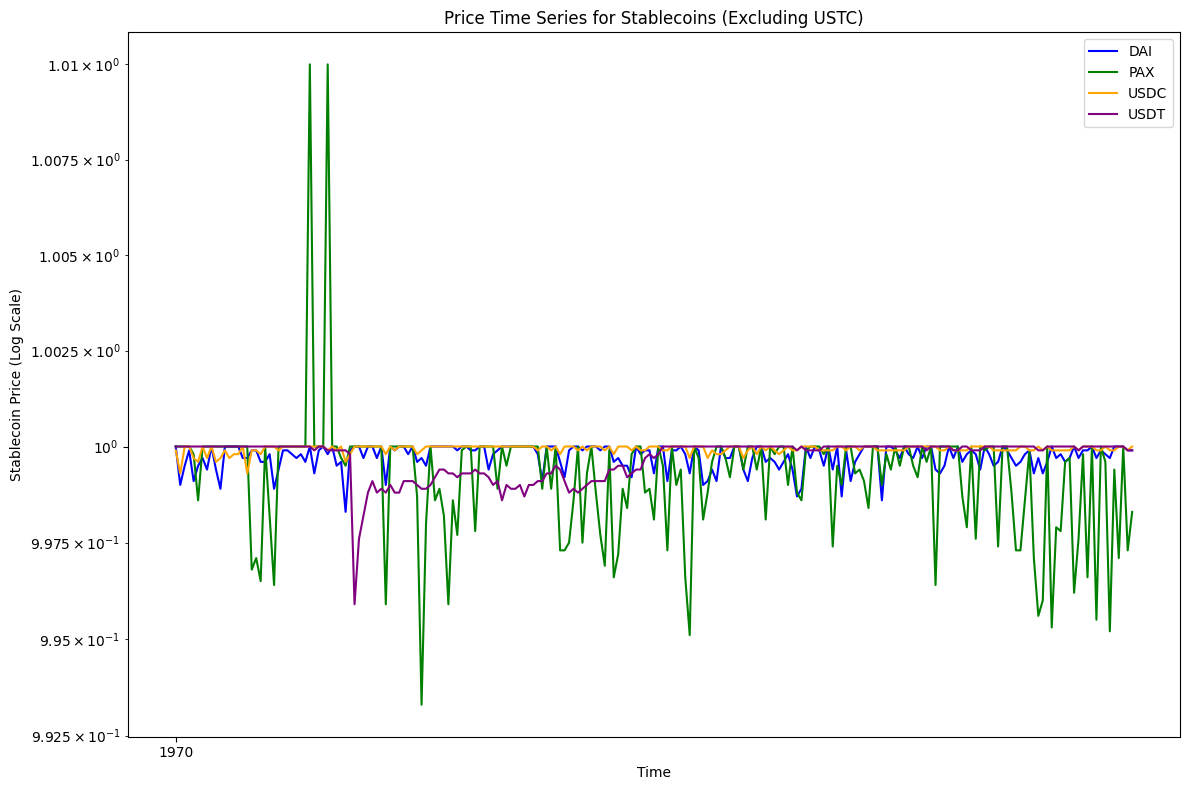

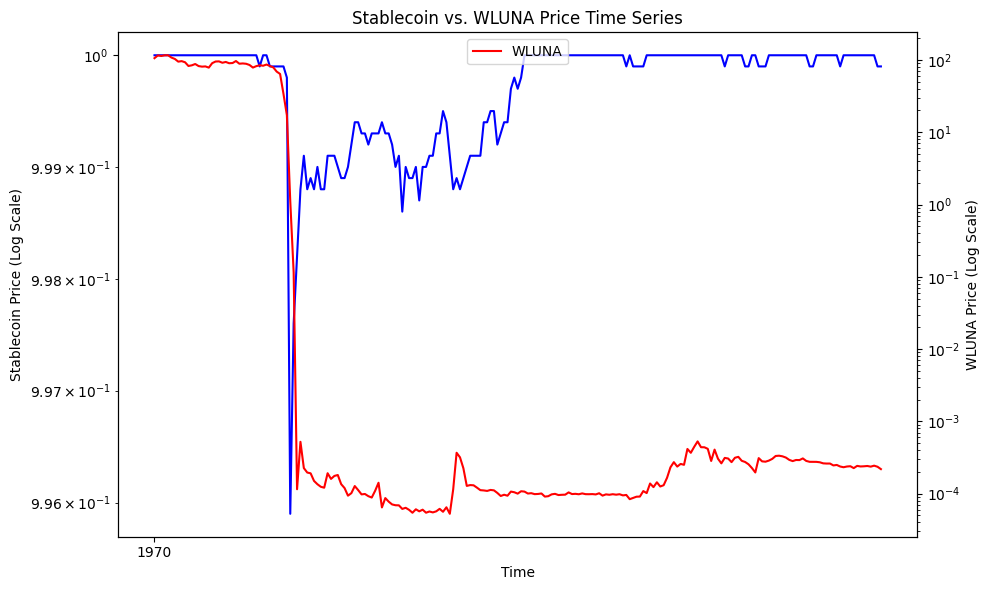

In [17]:
# Cell 3: Price Analysis (Dual-Axis with Log Scale)

# List the coins to be included in Chart 1: all except USTC and WLUNA.
other_stablecoins = [coin for coin in price_data.keys() if coin.lower() not in ['ustc', 'wluna']]

# Define distinct colors for these stablecoins.
stable_colors = ['blue', 'green', 'orange', 'purple']
color_map = {coin: stable_colors[i % len(stable_colors)] for i, coin in enumerate(other_stablecoins)}

# Create the figure for Chart 1.
fig, ax = plt.subplots(figsize=(12, 8))

for coin in other_stablecoins:
    df = price_data[coin]
    # Convert date/time information.
    if 'date' in df.columns:
        df['datetime'] = pd.to_datetime(df['date'])
    elif 'time_stamp' in df.columns:
        df['datetime'] = pd.to_datetime(df['time_stamp'], unit='s')
    else:
        df['datetime'] = pd.to_datetime(df.index)
        
    # Determine the price column (assume 'price' or 'close'; else use the first numeric column).
    if 'price' in df.columns:
        price_col = 'price'
    elif 'close' in df.columns:
        price_col = 'close'
    else:
        numeric_cols = df.select_dtypes(include='number').columns
        price_col = numeric_cols[0]
    
    # Plot each coin using its unique color.
    ax.plot(df['datetime'], df[price_col], label=coin.upper(), color=color_map[coin])

# Set log scale for y-axis.
ax.set_yscale('log')

# Label and title.
ax.set_xlabel('Time')
ax.set_ylabel('Stablecoin Price (Log Scale)')
ax.set_title('Price Time Series for Stablecoins (Excluding USTC)')
ax.legend()
plt.tight_layout()
plt.show()
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

# Plot stablecoin price on ax1 and WLUNA on ax2 (assume 'price_df' contains appropriate data)
stablecoins = {'usdt': price_df}  # extend with other stablecoins if needed
wluna_df = pd.read_csv('E:/Working/ERC20-stablecoins/price_data_extracted/price_data/wluna_price_data.csv')
wluna_df['datetime'] = pd.to_datetime(wluna_df['date']) if 'date' in wluna_df.columns else pd.to_datetime(wluna_df.index)

colors = ['blue', 'green', 'orange', 'purple', 'brown']
for i, (coin, df_coin) in enumerate(stablecoins.items()):
    df_coin['datetime'] = pd.to_datetime(df_coin['date']) if 'date' in df_coin.columns else pd.to_datetime(df_coin.index)
    price_col = 'price' if 'price' in df_coin.columns else 'close'
    ax1.plot(df_coin['datetime'], df_coin[price_col], label=coin.upper(), color=colors[i % len(colors)])
    
price_col_wluna = 'price' if 'price' in wluna_df.columns else 'close'
ax2.plot(wluna_df['datetime'], wluna_df[price_col_wluna], label='WLUNA', color='red')

ax1.set_xlabel('Time')
ax1.set_ylabel('Stablecoin Price (Log Scale)')
ax2.set_ylabel('WLUNA Price (Log Scale)')
ax1.set_yscale('log')
ax2.set_yscale('log')
plt.legend(loc='upper center')
plt.title('Stablecoin vs. WLUNA Price Time Series')
plt.tight_layout()
plt.show()


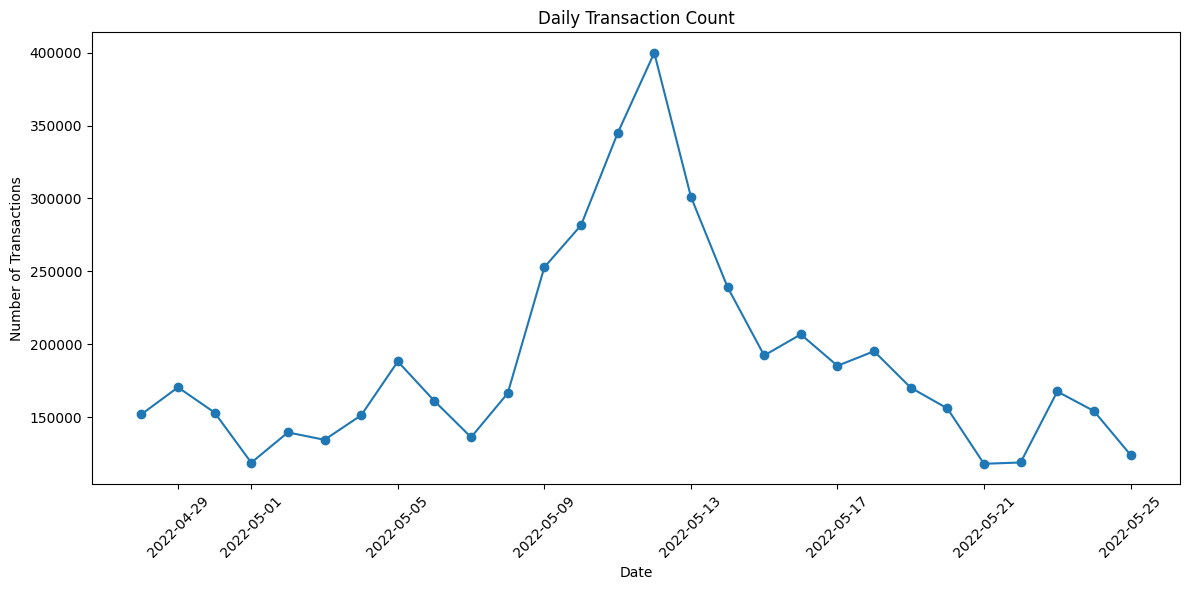

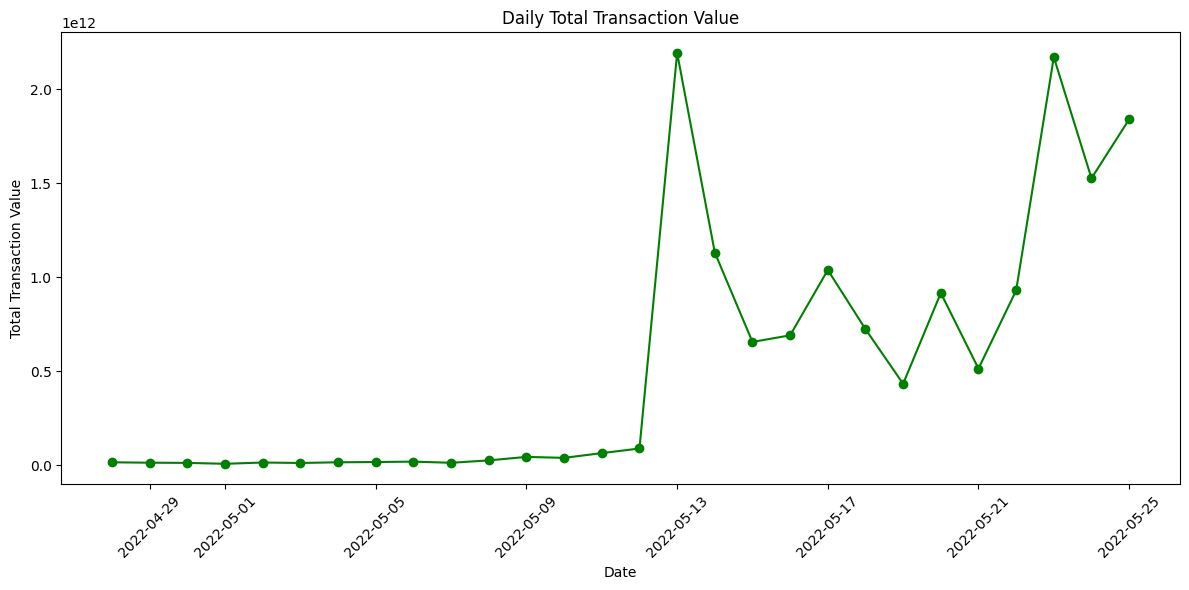

In [6]:
# Cell 4: Transaction EDA
df['date'] = df['datetime'].dt.date
daily_agg = df.groupby('date').agg(num_transactions=('transaction_index', 'count'),
                                   total_value=('value', 'sum')).reset_index()

plt.figure(figsize=(12,6))
plt.plot(daily_agg['date'], daily_agg['num_transactions'], marker='o')
plt.xlabel('Date'); plt.ylabel('Number of Transactions')
plt.title('Daily Transaction Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(daily_agg['date'], daily_agg['total_value'], marker='o', color='green')
plt.xlabel('Date'); plt.ylabel('Total Transaction Value')
plt.title('Daily Total Transaction Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Original DataFrame shape: (5280131, 8)
Filtered DataFrame shape: (3211956, 8)
Number of unique addresses: 429406


C:\Users\PC\AppData\Local\Temp\ipykernel_29800\330509936.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['date'] = df['datetime'].dt.date
C:\Users\PC\AppData\Local\Temp\ipykernel_29800\330509936.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


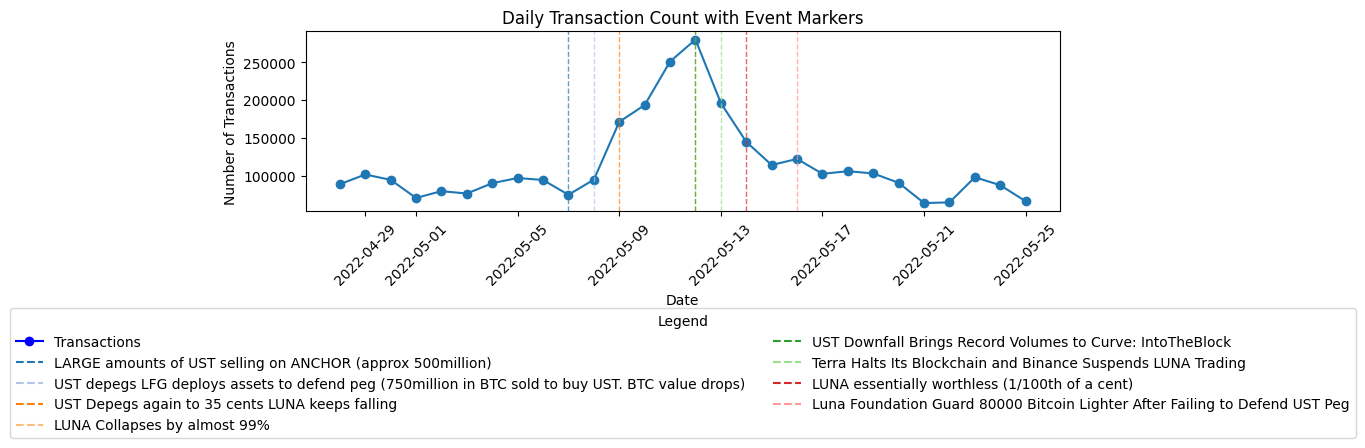

In [26]:
import matplotlib.lines as mlines
# 1. Load your transaction data
df = pd.read_csv('token_transfers.csv')
df['datetime'] = pd.to_datetime(df['time_stamp'], unit='s')

outflow = df.groupby('from_address')['value'].sum()
inflow  = df.groupby('to_address')['value'].sum()

# Combine inflow + outflow into a single Series
addresses_total_value = outflow.add(inflow, fill_value=0)

# 3. Define threshold and find addresses that meet it
THRESH = 10000
addresses_to_keep = addresses_total_value[addresses_total_value >= THRESH].index

# 4. Filter the original DataFrame to keep only transactions
#    where both 'from_address' and 'to_address' pass the threshold
df_filtered = df[
    df['from_address'].isin(addresses_to_keep) &
    df['to_address'].isin(addresses_to_keep)
]

print("Original DataFrame shape:", df.shape)
print("Filtered DataFrame shape:", df_filtered.shape)
print("Number of unique addresses:", len(addresses_to_keep))
df_filtered['date'] = df['datetime'].dt.date
# Daily aggregation for transactions
daily_agg = df_filtered.groupby('date').agg(
    num_transactions=('transaction_index', 'count'),
    total_value=('value', 'sum')
).reset_index()

# Determine the min and max date in your transaction data
start_date = daily_agg['date'].min()
end_date = daily_agg['date'].max()

# 2. Load your event data
events = pd.read_csv('event_data.csv', encoding='cp1252')
events['datetime'] = pd.to_datetime(events['timestamp'], unit='s')
events['date'] = events['datetime'].dt.date

# 3. Filter events to only include those within the daily_agg date range
filtered_events = events[(events['date'] >= start_date) & (events['date'] <= end_date)]

# 4. Create the plot for daily transactions
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(daily_agg['date'], daily_agg['num_transactions'], marker='o', linestyle='-', label='Transactions')
ax.set_xlabel('Date')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylabel('Number of Transactions')
ax.set_title('Daily Transaction Count with Event Markers')

# 5. Assign each unique event name a distinct color
unique_events = filtered_events['event'].unique()
colors = plt.cm.tab20.colors  # up to 20 distinct colors
event_color_map = {
    ev_name: colors[i % len(colors)] for i, ev_name in enumerate(unique_events)
}

# 6. Plot a vertical line for each event in filtered_events
for _, row in filtered_events.iterrows():
    ev_name = row['event']
    c = event_color_map[ev_name]
    ax.axvline(x=row['date'], color=c, linestyle='--', linewidth=1, alpha=0.7)

# 7. Create custom legend handles (one per unique event)
handles = []
for ev_name in unique_events:
    c = event_color_map[ev_name]
    handles.append(mlines.Line2D([], [], color=c, linestyle='--', label=ev_name))

# 8. Combine handles with the existing line for "Transactions"
trans_line = mlines.Line2D([], [], color='blue', marker='o', linestyle='-', label='Transactions')
all_handles = [trans_line] + handles

# 9. Place the legend
ax.legend(
    handles=all_handles, 
    loc='upper center',            # Center horizontally
    bbox_to_anchor=(0.5, -0.5),   # Shift below the axes
    ncol=2,                        # Number of columns in the legend
    title="Legend"
)

plt.tight_layout()
plt.show()


In [29]:
# Cell 5: Graph Construction & Degree Centrality
G = nx.from_pandas_edgelist(df, source='from_address', target='to_address', edge_attr='value', create_using=nx.DiGraph())
deg_centrality = nx.degree_centrality(G)
top100 = sorted(deg_centrality, key=lambda node: deg_centrality[node], reverse=True)[:100]


In [30]:

# Define the analysis window (daily slices)
date_range = pd.date_range('2022-05-01', '2022-05-25', freq='D')

# List to store daily centrality data
records = []

# Loop over each day in the analysis window
for d in range(len(date_range) - 1):
    start_date = date_range[d]
    end_date = date_range[d + 1]
    
    # Filter transactions for the day
    daily_subset = df_filtered[(df_filtered['datetime'] >= start_date) & (df_filtered['datetime'] < end_date)]
    
    # Build a graph for this day
    G_day = nx.from_pandas_edgelist(
        daily_subset,
        source='from_address',
        target='to_address',
        edge_attr='value',
        create_using=nx.DiGraph()
    )
    
    # Compute degree centrality for the day
    day_deg = nx.degree_centrality(G_day)
    
    # For each top participant, record the centrality (0 if not present)
    for participant in top100:
        records.append({
            'date': start_date,
            'participant': participant,
            'degree_centrality': day_deg.get(participant, 0)
        })

# Convert the records to a DataFrame
centrality_df = pd.DataFrame(records)
print(centrality_df.head(10))

        date                                 participant  degree_centrality
0 2022-05-01  0x28c6c06298d514db089934071355e5743bf21d60           0.089056
1 2022-05-01  0x3cd751e6b0078be393132286c442345e5dc49699           0.022381
2 2022-05-01  0xb5d85cbf7cb3ee0d56b3bb207d5fc4b82f43f511           0.021180
3 2022-05-01  0x503828976d22510aad0201ac7ec88293211d23da           0.025983
4 2022-05-01  0x74de5d4fcbf63e00296fd95d33236b9794016631           0.049865
5 2022-05-01  0x71660c4005ba85c37ccec55d0c4493e66fe775d3           0.014409
6 2022-05-01  0x2faf487a4414fe77e2327f0bf4ae2a264a776ad2           0.036423
7 2022-05-01  0xec30d02f10353f8efc9601371f56e808751f396f           0.026350
8 2022-05-01  0x0d0707963952f2fba59dd06f2b425ace40b492fe           0.049598
9 2022-05-01  0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640           0.067276


In [32]:
def shorten_address(address):
    """
    Shorten an Ethereum address (or similar string) to first 4 and last 4 characters.
    Example: 0xabcdef1234567890 -> 0xabcd...7890
    """
    # Safety check: if the address is shorter than 10 chars, just return it
    if len(address) < 10:
        return address
    
    # Take first 6 to include '0x' + 4 hex chars, then '...' + last 4
    return address[:4] + "..." + address[-4:]

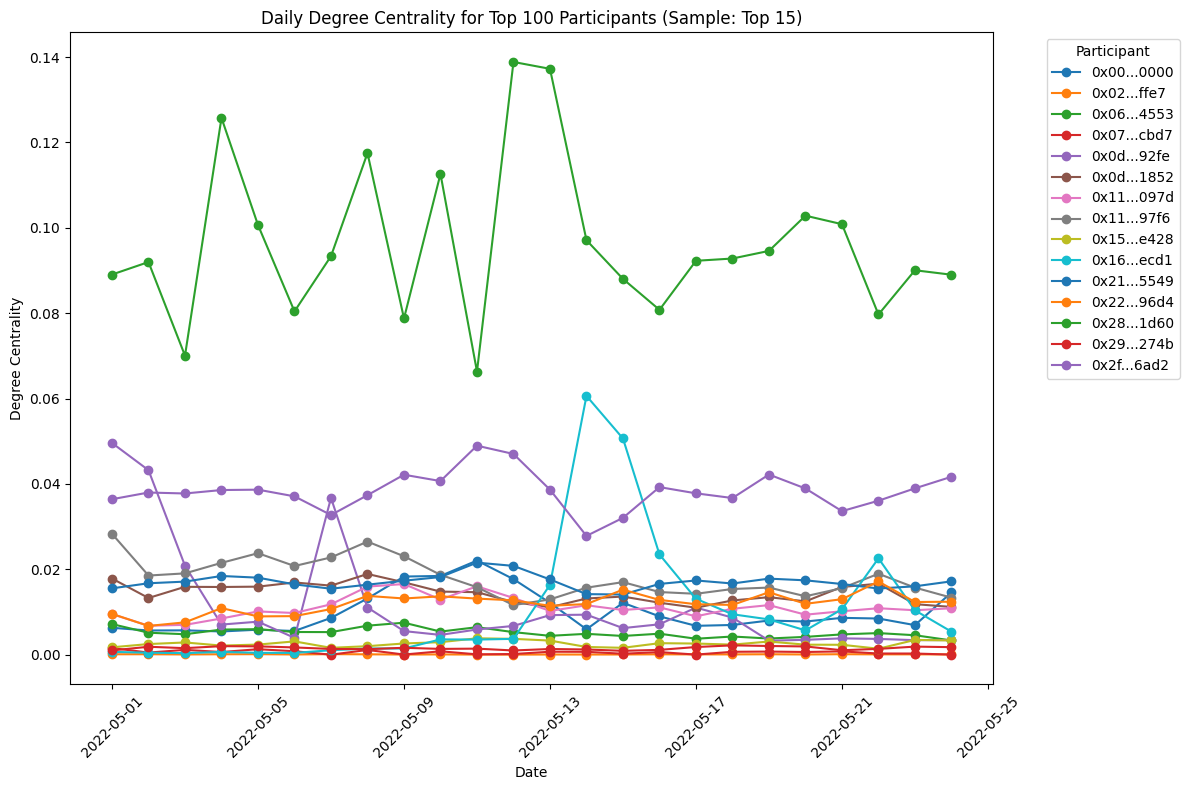

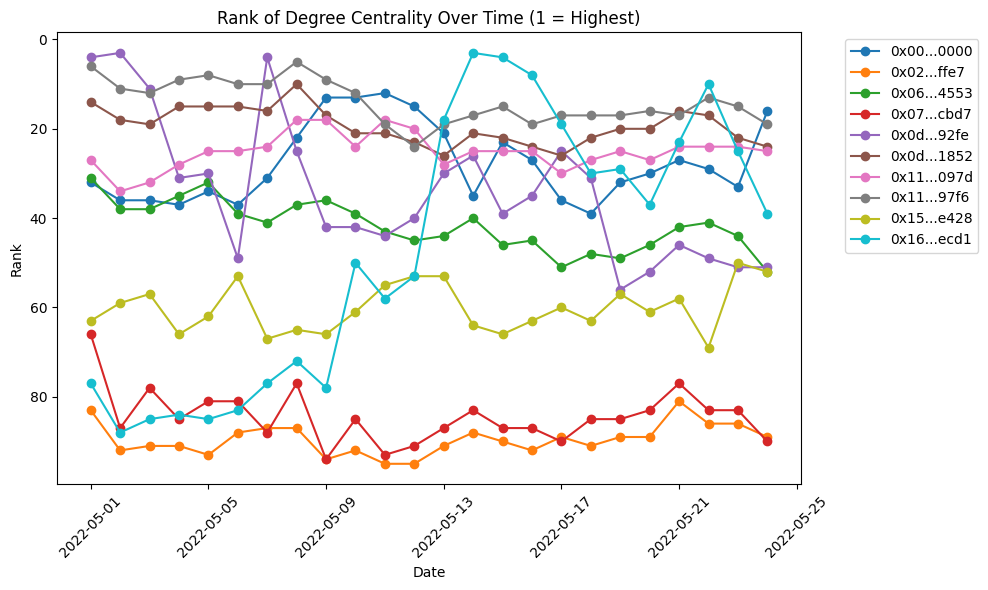

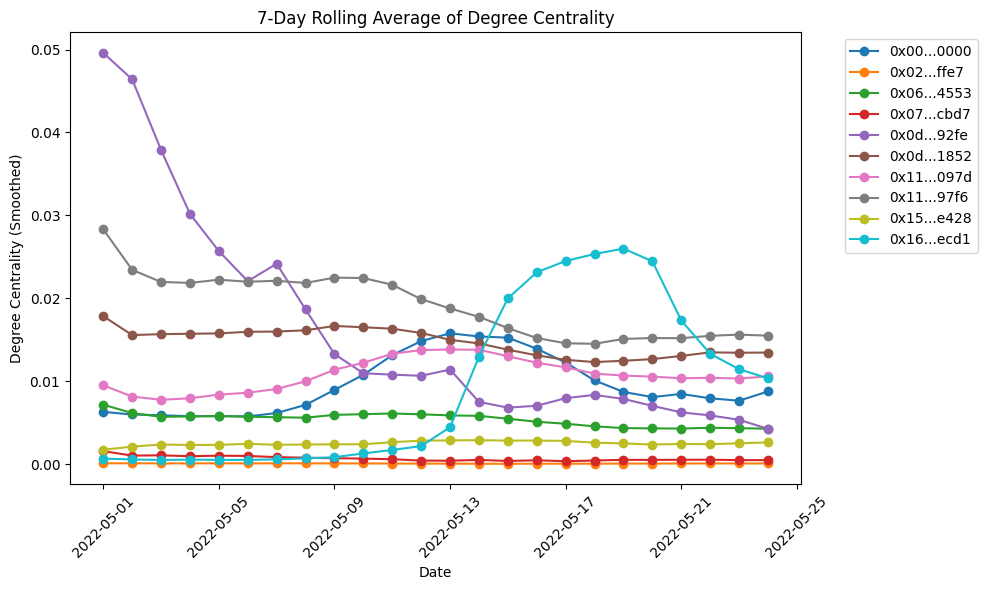

In [33]:
# Cell 6: Temporal Graph Analysis (Rolling 7-Day Mean of Degree Centrality)

# Pivot data: rows = dates, columns = participants, values = degree centrality
pivot_df = centrality_df.pivot(index='date', columns='participant', values='degree_centrality')
# Create a mapping of full_address -> shortened_address
rename_map = {addr: shorten_address(addr) for addr in pivot_df.columns}

# Rename the columns in pivot_df in-place
pivot_df.rename(columns=rename_map, inplace=True)

# Plot sample time series for the top 5 participants
plt.figure(figsize=(12, 8))
sample_participants = pivot_df.columns[:15]  # change or loop through more as needed
for participant in sample_participants:
    plt.plot(pivot_df.index, pivot_df[participant], marker='o', label=participant)

plt.xlabel('Date')
# apply logaritmic scale to y-axis

plt.ylabel('Degree Centrality')
plt.title('Daily Degree Centrality for Top 100 Participants (Sample: Top 15)')
plt.xticks(rotation=45)
plt.legend(title='Participant', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

ranked_df = pivot_df.rank(axis=1, ascending=False, method='dense')

# Now, each value is the rank (1 = highest degree centrality).
# Plot a few participants’ ranks:
participants_to_plot = pivot_df.columns[:10]
plt.figure(figsize=(10, 6))
for participant in participants_to_plot:
    plt.plot(ranked_df.index, ranked_df[participant], marker='o', label=participant)

plt.gca().invert_yaxis()  # So that rank #1 is at the top
plt.title('Rank of Degree Centrality Over Time (1 = Highest)')
plt.xlabel('Date')
plt.ylabel('Rank')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

rolling_df = pivot_df.rolling(window=7, min_periods=1).mean()

# Plot the smoothed data for a few participants
participants_to_plot = rolling_df.columns[:10]
plt.figure(figsize=(10, 6))
for participant in participants_to_plot:
    plt.plot(rolling_df.index, rolling_df[participant], marker='o', label=participant)

plt.title('7-Day Rolling Average of Degree Centrality')
plt.xlabel('Date')
plt.ylabel('Degree Centrality (Smoothed)')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



In [9]:
# Cell 7: Pre-Event Community Detection & Static Partitioning
event_date = pd.to_datetime('2022-05-12')
df_pre = df[df['datetime'] < event_date]
grouped_pre = df_pre.groupby(['from_address', 'to_address'])['value'].sum().reset_index(name='volume_pre')
G_pre = nx.from_pandas_edgelist(grouped_pre, source='from_address', target='to_address', edge_attr='volume_pre', create_using=nx.DiGraph())
G_pre_undirected = G_pre.to_undirected()
partition_pre = community_louvain.best_partition(G_pre_undirected, weight='volume_pre')
pre_community_sizes = Counter(partition_pre.values())


In [10]:
# Cell 8: Community Volume Aggregation (Pre & Post)
pre_community_volumes = {}
for u, v, data in G_pre_undirected.edges(data=True):
    comm = partition_pre[u]
    pre_community_volumes.setdefault(comm, 0)
    pre_community_volumes[comm] += data['volume_pre']

df_post = df[df['datetime'] >= event_date]
grouped_post = df_post.groupby(['from_address', 'to_address'])['value'].sum().reset_index(name='volume_post')
G_post = nx.from_pandas_edgelist(grouped_post, source='from_address', target='to_address', edge_attr='volume_post', create_using=nx.DiGraph())
G_post_undirected = G_post.to_undirected()

post_community_volumes = {}
for u, v, data in G_post_undirected.edges(data=True):
    if u in partition_pre:
        comm = partition_pre[u]
        post_community_volumes.setdefault(comm, 0)
        post_community_volumes[comm] += data['volume_post']


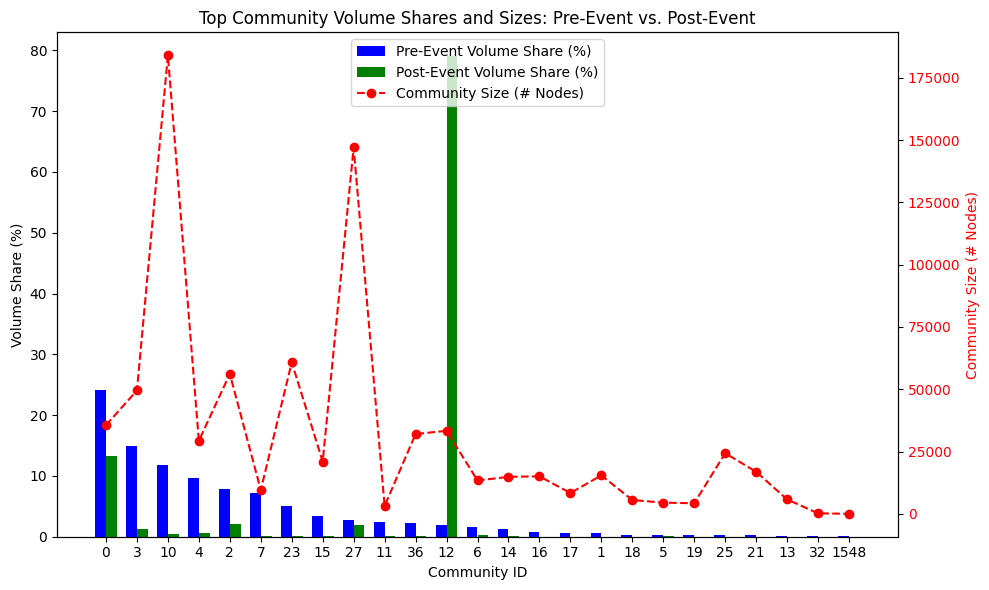

In [13]:
# Cell 9: Visualization of Community Volume Shares and Sizes (Top 25)
sorted_pre_vol = sorted(pre_community_volumes.items(), key=lambda x: x[1], reverse=True)[:25]
top_ids = [item[0] for item in sorted_pre_vol]
top_pre_volumes = [item[1] for item in sorted_pre_vol]
pre_total = sum(pre_community_volumes.values())
post_total = sum(post_community_volumes.values()) if post_community_volumes else 1

top_pre_shares = [vol / pre_total * 100 for vol in top_pre_volumes]
top_post_shares = [post_community_volumes.get(cid, 0) / post_total * 100 for cid in top_ids]
top_sizes = [pre_community_sizes.get(cid, 0) for cid in top_ids]

x = np.arange(len(top_ids))
width = 0.35
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.bar(x - width/2, top_pre_shares, width, label='Pre-Event Volume Share (%)', color='blue')
ax1.bar(x + width/2, top_post_shares, width, label='Post-Event Volume Share (%)', color='green')
ax1.set_xlabel('Community ID')
ax1.set_ylabel('Volume Share (%)')
ax1.set_xticks(x)
ax1.set_xticklabels([str(cid) for cid in top_ids])
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(x, top_sizes, color='red', marker='o', linestyle='--', label='Community Size (# Nodes)')
ax2.set_ylabel('Community Size (# Nodes)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center')

ax1.set_title('Top Community Volume Shares and Sizes: Pre-Event vs. Post-Event')
plt.tight_layout()
plt.show()


In [14]:
# Cell 10: Identification of "Interesting" Communities (Small size, High Volume)
SIZE_THRESHOLD = 100
VOLUME_SHARE_THRESHOLD = 0.1
pre_total = sum(pre_community_volumes.values())
pre_community_shares = {cid: (vol / pre_total) * 100 for cid, vol in pre_community_volumes.items()}

interesting_communities = []
for cid, size in pre_community_sizes.items():
    share = pre_community_shares.get(cid, 0)
    if size < SIZE_THRESHOLD and share > VOLUME_SHARE_THRESHOLD:
        interesting_communities.append((cid, size, share))

interesting_communities.sort(key=lambda x: x[2], reverse=True)
print("Communities with < 100 nodes but volume share > 0.1%:")
for cid, size, share in interesting_communities:
    print(f"Community {cid}: size={size}, volume_share={share:.2f}%")


Communities with < 100 nodes but volume share > 0.1%:
